In [1]:
import torch
import torch.nn.functional as F
import os
from models import Siren, SirenModulated
from utils import multilabel_sdm, dotdict, compute_metrics_single, visualize_differences, evaluate
from tqdm.notebook import trange, tqdm
import json

import matplotlib.pyplot as plt

os.environ['GPU_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
from torchsummary import summary

In [ ]:
data = torch.load('data/JSRT_img0_lms_seg_shifted.pth')
seg = data['JSRT_seg_shifted']#.permute(0, 2, 3, 1)
sdms = torch.load('data/JSRT_translated_sdms.pth')
dropouts = torch.load('data/dropouts.pth')
#0-160 Training
#160-247 Testing

#choose trained model
model_path = 'results/73-smooth-fog'

#read config in args.json
with open(os.path.join(model_path, 'args.json'), 'r') as f:
    args = dotdict(json.load(f))

#initialize model
#def __init__(self,in_features, out_features, hidden_ch=256,scale=30,num_layers=3):
if args.model == 'Siren':
    model = Siren(in_features=2+args['codebook_sz'], out_features=5, hidden_ch=args['channels'], num_layers=args['layers']).to(device)
elif args.model == 'SirenModulated':
    model = SirenModulated(in_features=2+args['codebook_sz'], out_features=5, hidden_ch=args['channels'], num_layers=args['layers']).to(device)
#load model

epx_str = str(args.epochs-1)
optimized_data = torch.load(os.path.join(model_path, f'model_{epx_str}.pth'))
model.load_state_dict(optimized_data['model'])

latent_codes = optimized_data['codebook'].detach().cpu()
N = args['num_samples']
C,H,W = seg.shape[-3:]
mesh = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W)).to(device)
## Compute SSM
mean_shape = latent_codes.mean(dim=0)
cov_matrix = torch.matmul((latent_codes - mean_shape).T, (latent_codes - mean_shape)) / latent_codes.shape[0]
eigenvalues_, eigenvectors_ = torch.linalg.eig(cov_matrix)
eigenvalues_, indices = torch.sort(eigenvalues_.float(), descending=True)
eigenvectors_ = eigenvectors_[:, indices].float()
# plt.plot(eigenvalues_/eigenvalues_.sum())
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance')
# plt.title('Explained Variance')
# plt.show()


/home/grossbroehmer/mambaforge/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/tmp/ipykernel_1993575/3456187337.py:39: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1704987290837/work/aten/src/ATen/native/Copy.cpp:301.)
  eigenvalues_, indices = torch.sort(eigenvalues_.float(), descending=True)


In [7]:
args['codebook_sz']

14

In [6]:
#summary
summary(model,[(2+args['codebook_sz'],)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Linear: 2-1                       [-1, 128]                 384
├─Sequential: 1                          []                        --
|    └─Linear: 2-2                       [-1, 256]                 3,840
├─Sequential: 1                          []                        --
|    └─Linear: 2-3                       [-1, 128]                 16,512
├─Sequential: 1                          []                        --
|    └─Linear: 2-4                       [-1, 256]                 3,840
├─Sequential: 1                          []                        --
|    └─Linear: 2-5                       [-1, 128]                 16,512
├─Sequential: 1                          []                        --
|    └─Linear: 2-6                       [-1, 256]                 3,840
├─Sequential: 1                          []                        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Linear: 2-1                       [-1, 128]                 384
├─Sequential: 1                          []                        --
|    └─Linear: 2-2                       [-1, 256]                 3,840
├─Sequential: 1                          []                        --
|    └─Linear: 2-3                       [-1, 128]                 16,512
├─Sequential: 1                          []                        --
|    └─Linear: 2-4                       [-1, 256]                 3,840
├─Sequential: 1                          []                        --
|    └─Linear: 2-5                       [-1, 128]                 16,512
├─Sequential: 1                          []                        --
|    └─Linear: 2-6                       [-1, 256]                 3,840
├─Sequential: 1                          []                        

In [3]:
def predict(model, latent_codes, H=256, W=256, C=5, device='cuda', batch_size_=16):
    N = latent_codes.size(0)  
    model = model.to(device)
    model.eval()
    
    predictions = []
    
    with torch.no_grad():
        for i in range(0, N, batch_size_):  # Process 16 images at a time
            end = min(i + batch_size_, N)  # Ensure we don't go out of bounds
            latent_codes_batch = latent_codes[i:end]  # Get the current batch of latent codes
            batch_size = latent_codes_batch.size(0)
            
            mesh = F.affine_grid(torch.eye(2, 3).unsqueeze(0), (1, 1, H, W)).to(device).repeat(batch_size, 1, 1, 1).view(batch_size, -1, 2)
            latent_codes_batch = latent_codes_batch.unsqueeze(1).repeat(1, H * W, 1).to(device)
            
            mesh = torch.cat([mesh, latent_codes_batch], dim=-1)
            pred = model(mesh)
            predictions.append(pred.view(batch_size, H, W,C).cpu())
            
    
    return torch.cat(predictions, dim=0)  

def optimize_latent_codes(model, targets, masks=None, latent_code_sz=14, device='cuda', num_steps=500, batch_size_=8):
    N,H,W,C = targets.size()
    model = model.to(device)
    model.eval()

    out_latent_codes = []
    all_losses = []
    
    for i in trange(0,N,batch_size_):
        losses = []
        end = min(i+batch_size_,N)
        targets_batch = targets[i:end].to(device)
        masks_batch = masks[i:end].to(device) if masks is not None else None
        batch_size = targets_batch.size(0)

        test_latent_code = torch.randn(batch_size, latent_code_sz).to(device)*1e-8
        test_latent_code.requires_grad = True
        optimizer_codes = torch.optim.Adam([test_latent_code],lr=5e-3)
        pbar = tqdm(range(num_steps))
        for step in pbar:
            optimizer_codes.zero_grad()
            mesh = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W)).to(device).repeat(batch_size,1,1,1).view(batch_size,-1,2)
            input_ = torch.cat([mesh,test_latent_code.unsqueeze(1).repeat(1,H*W,1)],dim=-1)
            pred = model(input_)
            #print(pred.shape, targets_batch.shape)
            loss = F.mse_loss(torch.tanh(pred).view(batch_size,-1,C),targets_batch.view(batch_size,-1,C), reduction='none')
            if masks_batch is not None:
                loss = loss*masks_batch.view(batch_size,H*W,1)
            loss = loss.mean()
            loss.backward()
            optimizer_codes.step()
            losses.append(loss.item())

            pbar.set_description(f'Loss: {loss.item():.4f}')
        all_losses.append(losses)
        out_latent_codes.append(test_latent_code.detach().cpu())

    return torch.cat(out_latent_codes,dim=0), all_losses


In [4]:
optimized_latents = {}


In [5]:
targets = sdms[160:]

test_latent_codes, losses = optimize_latent_codes(model, targets, device=device, batch_size_=8, num_steps=150)
optimized_latents['test'] = test_latent_codes

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

/home/grossbroehmer/mambaforge/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

/home/grossbroehmer/mambaforge/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


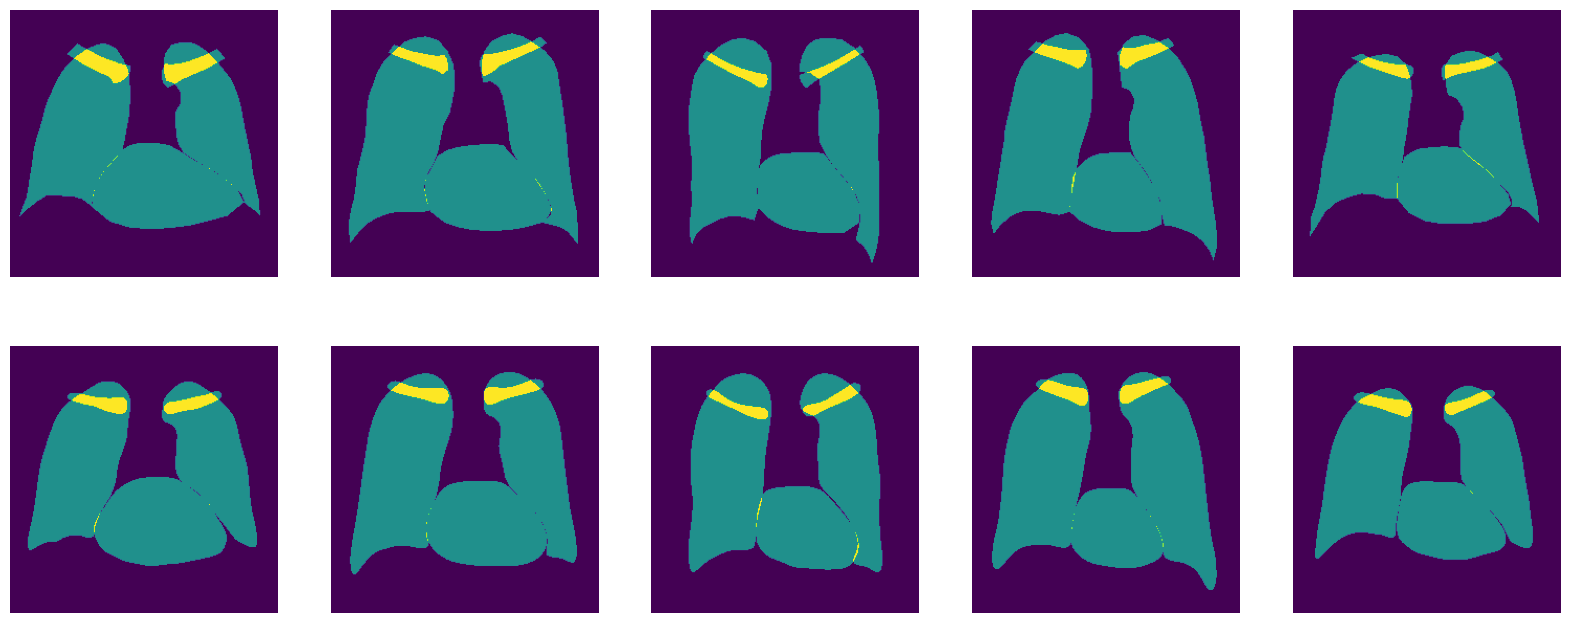

In [27]:
#generate predictions
predictions = predict(model, test_latent_codes, H=H, W=W, C=5, device=device, batch_size_=16)
predictions.shape

fig,ax = plt.subplots(2,5,figsize=(20,8))
for i in range(5):
    ax[0,i].imshow((targets[i,:,:]<0).sum(2).cpu().numpy())
    ax[1,i].imshow((predictions[i,:,:,:]<0).sum(2).cpu().numpy())
    #remove ax
    ax[0,i].axis('off')
    ax[1,i].axis('off')
plt.show()

In [30]:
dices = []
hds = []
for i in range(87):
                
                #dsc, hd = compute_metrics_single(pred[0], sdms[160+i])
    #calculate dices,hd
    dsc, hd = compute_metrics_single(predictions[i], targets[i])
    dices.append(dsc)
    hds.append(hd)
dices = torch.stack(dices)
hds = torch.stack(hds)

print(f'Dice: {dices.mean(0)}, {dices.std(0)}, {dices.mean().item()}, {dices.std().item()}')
print(f'HD: {hds.mean(0)}, {hds.std(0)}', f'{hds.mean().item()}, {hds.std().item()}')

Dice: tensor([0.9602, 0.9474, 0.9601, 0.7781, 0.7604])


Dice: tensor([0.9602, 0.9474, 0.9601, 0.7781, 0.7604]), tensor([0.0183, 0.0244, 0.0182, 0.1266, 0.1277]), 0.8812419176101685, 0.12285545468330383
HD: tensor([3.6450, 4.2662, 2.9021, 3.6923, 4.0092]), tensor([1.7912, 2.0177, 1.5296, 2.0938, 2.1774]) 3.7029380798339844, 1.9814164638519287


In [8]:
for strength in [80]:#,80,120,160]:
    masks = dropouts[str(strength)]
    masked_segmentations = seg[160:]*masks.unsqueeze(1)
    masked_sdms = []
    for i in trange(masked_segmentations.shape[0]):
        masked_sdms.append(multilabel_sdm(masked_segmentations[i]).permute(1,2,0))
    print('Created masked sdms')
    masked_sdms = torch.stack(masked_sdms)

    print('Optimize Masked latent Codes with Mask-Loss')
    test_latent_codes_mask, losses = optimize_latent_codes(model, masked_sdms, device=device, batch_size_=8, num_steps=150, masks=masks.view(-1,1,H,W))
    optimized_latents[f'mask_{strength}_loss'] = test_latent_codes_mask
    print('Optimize Masked latent Codes without Mask-Loss')
    test_latent_codes_mask_noloss, losses = optimize_latent_codes(model, masked_sdms, device=device, batch_size_=8, num_steps=450, masks=None)
    optimized_latents[f'mask_{strength}_noloss'] = test_latent_codes_mask_noloss


  0%|          | 0/87 [00:00<?, ?it/s]

Created masked sdms
Optimize Masked latent Codes with Mask-Loss


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Optimize Masked latent Codes without Mask-Loss


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

In [18]:
#save in args.save_path
new_save_path = args.save_path.replace('/falta/', '/grossbroehmer/').replace('fenjafalta_658025', 'christophgrossbroeh/projects')
#create folder if not exists
if not os.path.exists(new_save_path):
    os.makedirs(new_save_path)
torch.save(optimized_latents, os.path.join(new_save_path, 'optimized_latents.pth'))

In [62]:
optimized_latents.keys()
#find all keys with "*noloss" in it
noloss_keys = [key for key in optimized_latents.keys() if 'noloss' in key]

##evaluate over all keys
metrics = {}
for key in optimized_latents.keys():
    print(f'Evaluate {key}')
    pred = predict(model, optimized_latents[key], H=H, W=W, C=5, device=device, batch_size_=8)
    if 'noloss' in key or key == 'test':
        dices = []
        hds = []

        q = optimized_latents[key]

        pred = predict(model, q, H=H, W=W, C=5, device=device, batch_size_=8)
        for i in trange(pred.shape[0]):
            centered = q[i] - mean_shape
            projected = torch.matmul(centered, eigenvectors_)

            inner_dices = []
            inner_hds = []
            for k in range(eigenvalues_.shape[0]+1):
                if k == 0:
                    reconstructed = mean_shape 
                else:
                    reduced_projection = projected[:k]
                    reduced_eigenvectors = eigenvectors_[:, :k]

                    reconstructed = mean_shape + torch.matmul(reduced_projection, reduced_eigenvectors.T)

                pred = predict(model, reconstructed.unsqueeze(0), H=H, W=W, C=5, device=device, batch_size_=8)
                dsc, hd = compute_metrics_single(pred[0], sdms[160+i])
                inner_dices.append(dsc)
                inner_hds.append(hd)
            dices.append(torch.stack(inner_dices))
            hds.append(torch.stack(inner_hds))
        dices = torch.stack(dices)
        hds = torch.stack(hds)
        metrics[f'{key}'] = {'hd':hds, 'dsc':dices}

    else:
        tmp_hd =[]
        tmp_dsc = []
        for i in range(pred.shape[0]):
            dsc, hd = compute_metrics_single(pred[i], sdms[160+i])
            tmp_hd.append(hd)
            tmp_dsc.append(dsc)
        metrics[f'{key}'] = {'hd':torch.stack(tmp_hd), 'dsc':torch.stack(tmp_dsc)}
        

Evaluate test


/home/grossbroehmer/mambaforge/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluate mask_80_loss
Evaluate mask_80_noloss


  0%|          | 0/87 [00:00<?, ?it/s]

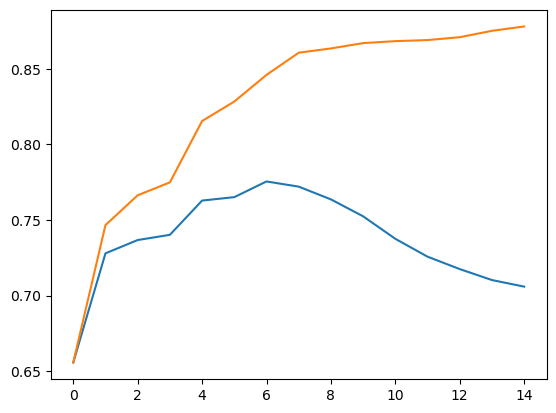

In [73]:
plt.plot(metrics['mask_80_noloss']['dsc'].mean(dim=0).mean(dim=1))
#plt.plot(metrics['mask_80_loss']['dsc'])
plt.plot(metrics['test']['dsc'].mean(dim=0).mean(dim=1))


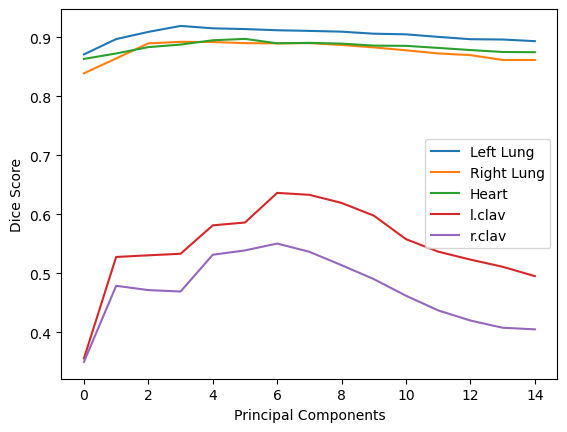

torch.Size([15, 5])

In [49]:
plt.plot(dices.mean(dim=0))
legend = ['Left Lung', 'Right Lung', 'Heart', 'l.clav', 'r.clav']
plt.legend(legend)
plt.xlabel('Principal Components')
plt.ylabel('Dice Score')
plt.show()

dices.mean(dim=0).shape

In [19]:
train_predictions = predict(model, latent_codes, H=H, W=W, C=5, device=device, batch_size_=16)
test_predictions = predict(model, test_latent_codes, H=H, W=W, C=5, device=device, batch_size_=16)

print(train_predictions.shape, test_predictions.shape)


/home/grossbroehmer/mambaforge/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([160, 256, 256, 5]) torch.Size([87, 256, 256, 5])


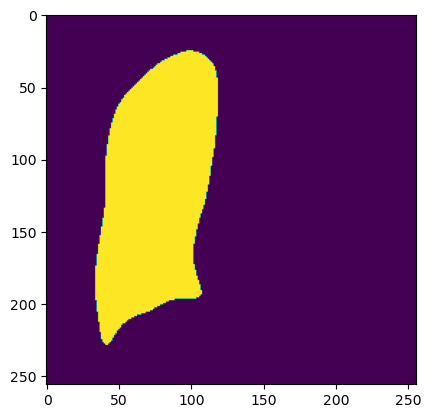

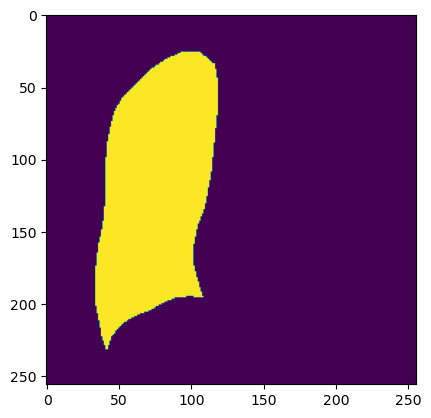

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

In [42]:
metrics = {}

tmp_hd = []
tmp_dsc = []
for i in trange(train_predictions.shape[0]):
    dsc, hd = compute_metrics_single(train_predictions[i], sdms[i])
    tmp_hd.append(hd)
    tmp_dsc.append(dsc)
metrics['train'] = {'hd': torch.stack(tmp_hd), 'dsc': torch.stack(tmp_dsc)}

for i in trange(test_predictions.shape[0]):
    dsc, hd = compute_metrics_single(test_predictions[i], sdms[i])
    tmp_hd.append(hd)
    tmp_dsc.append(dsc)
metrics['test'] = {'hd': torch.stack(tmp_hd), 'dsc': torch.stack(tmp_dsc)}




In [46]:
print('Train')
print(f'HD: {metrics["train"]["hd"].mean(0)}, DSC: {metrics["train"]["dsc"].mean(0)}')
print('Test')
print(f'HD: {metrics["test"]["hd"].mean(0)}, DSC: {metrics["test"]["dsc"].mean(0)}')

Train
HD: tensor([0.7673, 0.7857, 0.8446, 0.8301, 0.8043]), DSC: tensor([0.9903, 0.9865, 0.9869, 0.9484, 0.9473])
Test
HD: tensor([5.1835, 5.4018, 4.3286, 4.3542, 4.4870]), DSC: tensor([0.9365, 0.9199, 0.9310, 0.7068, 0.7013])


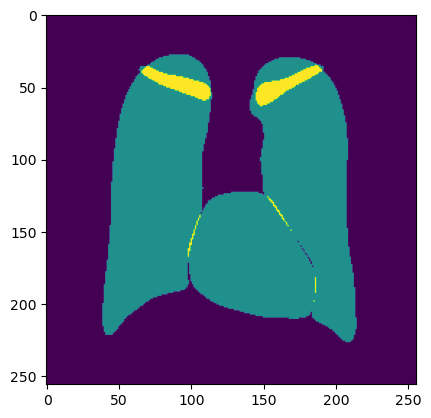

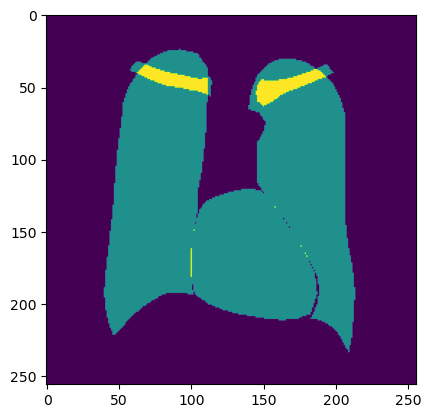

In [56]:
plt.imshow((test_predictions[10,:,:,]<0).sum(2))
plt.show()
plt.imshow((sdms[160+10,:,:]<0).sum(2))
plt.show()

In [51]:
masks = dropouts['40']
masked_segmentations = seg[160:]*masks.unsqueeze(1)
masked_sdms = []
for i in trange(masked_segmentations.shape[0]):
    masked_sdms.append(multilabel_sdm(masked_segmentations[i]).permute(1,2,0))
masked_sdms = torch.stack(masked_sdms)[:10]

test_latent_codes_mask_40, losses = optimize_latent_codes(model, masked_sdms, device=device, batch_size_=8, num_steps=500, masks=masks[:10].view(-1,1,H,W))
#out_img = predict(model, test_latent_codes_mask_40, H=H, W=W, C=5, device=device, batch_size_=16)
test_latent_codes_mask_40_noloss, losses = optimize_latent_codes(model, masked_sdms, device=device, batch_size_=8, num_steps=500, masks=None)
#out_img_noloss = predict(model, test_latent_codes_mask_40_noloss, H=H, W=W, C=5, device=device, batch_size_=16)



  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/home/grossbroehmer/mambaforge/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

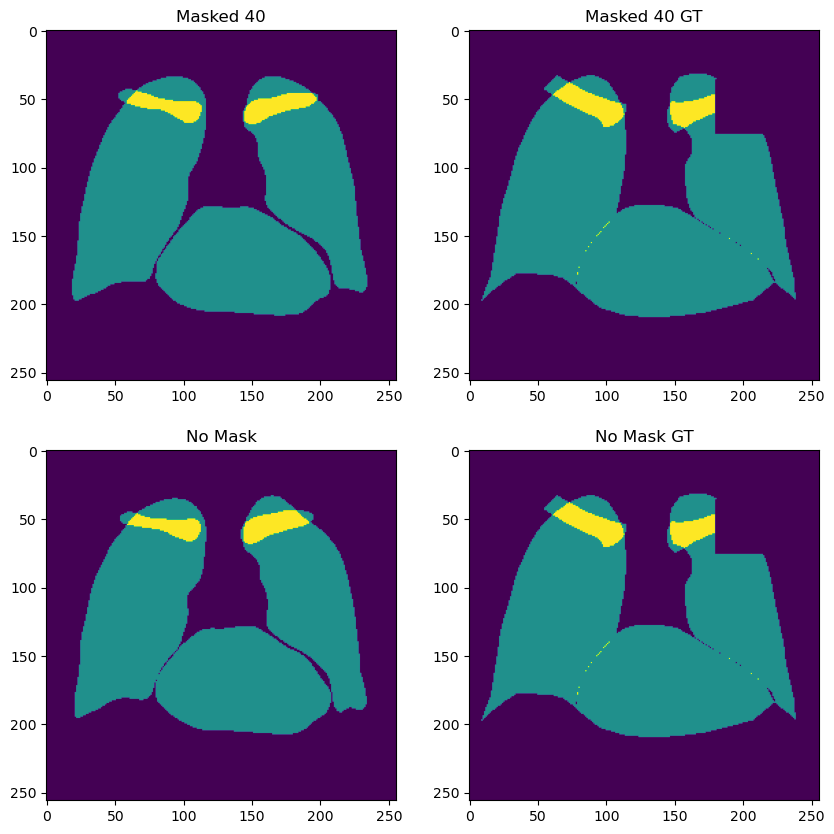

In [43]:
print(dropouts.keys()) # 80,120,160 

tmp = dropouts['40']
print(tmp.shape)

tt = seg[160:]*tmp.unsqueeze(1)



dict_keys(['40', '80', '120', '160'])
torch.Size([87, 256, 256])


torch.Size([256, 256])


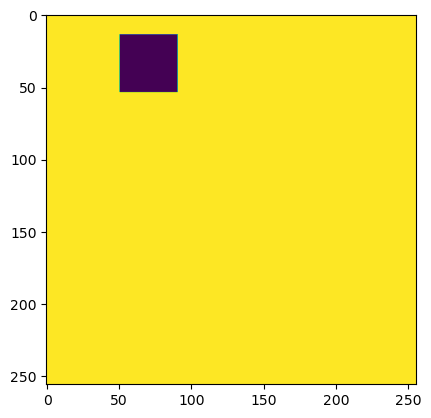

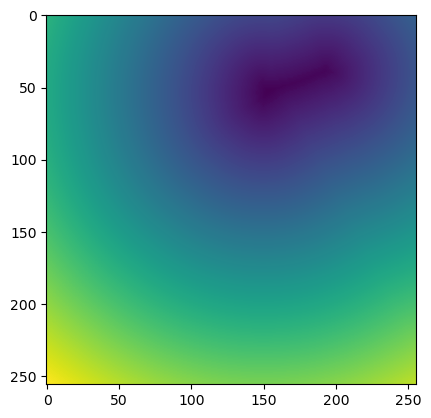

In [45]:
import scipy.ndimage as ndimage
import numpy as np

plt.imshow(tt[10,:,:].sum(0))
np.unique(tt[10,4])

def compute_sdm(mask):
    if mask.sum() == 0:
        return torch.zeros_like(mask, dtype=torch.float32)
    mask_np = mask.cpu().numpy()
    dist_outside = ndimage.distance_transform_edt(mask_np == 0)  # Distance to nearest 1 (inside object)
    dist_inside = ndimage.distance_transform_edt(mask_np == 1)   # Distance to nearest 0 (outside object)
    sdm = dist_outside - dist_inside
    
    return torch.tensor(sdm, dtype=torch.float32)

sdm = compute_sdm(tt[10,4])
plt.imshow(sdm)


torch.Size([5, 256, 256])


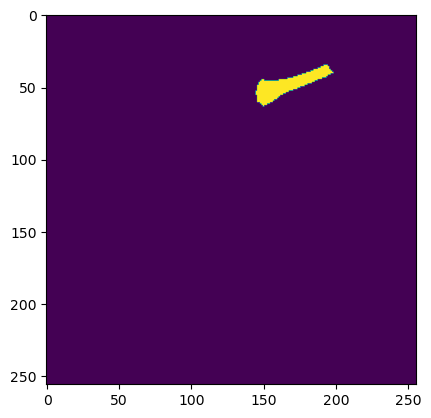

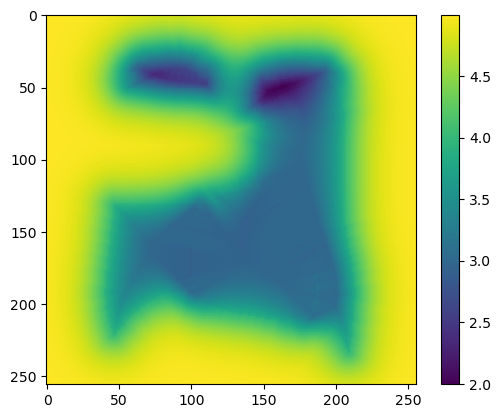

torch.Size([256, 256, 5])

In [30]:


#create sdm
print(tt[10].shape)
plt.imshow(tt[10,4])
plt.show()
test_sdm = multilabel_sdm(tt[10]).permute(1,2,0)
plt.imshow(test_sdm[:,:,:].sum(2))
plt.colorbar()
plt.show()


#fit code
test_sdm.shape

In [40]:

tmp_code, losses = optimize_latent_codes(model, test_sdm.unsqueeze(0), device=device, batch_size_=8, num_steps=500, masks=tmp[10].view(1,1,H,W))
out_img = predict(model, tmp_code, H=H, W=W, C=5, device=device, batch_size_=16)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

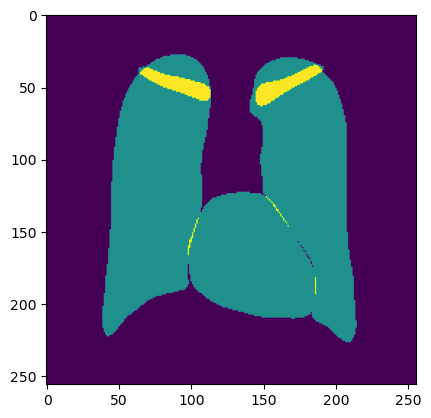

In [41]:
plt.imshow((out_img[0,:,:]<0).sum(2).cpu())